In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from collections import Counter
import pickle

In [2]:
RW_dataset_path = "C:\\Users\\hp-pc\\Desktop\\GRP\\real_data\\engineering\\engineering_total\\engineering_total.csv"

In [3]:
df_engineering_RW = pd.read_csv(RW_dataset_path, index_col=False)

In [5]:
df_engineering_RW = df_engineering_RW.dropna()

In [6]:
df_engineering_RW.pop('time')
df_engineering_RW.pop('posx')
df_engineering_RW.pop('posy')
df_engineering_RW.pop('yaw')
df_engineering_RW.pop('yaw_error')

0       -46.419603
1       -47.866942
2       -48.417687
3       -41.905376
4       -28.993614
           ...    
14766   -12.790343
14767   -12.881078
14768   -12.963495
14769   -13.099421
14770   -12.929873
Name: yaw_error, Length: 14771, dtype: float64

In [89]:
def change_yaw(x):
    if x < 0:
        x += 360
    return x

df_engineering_RW['yaw_c'] = df_engineering_RW['yaw_c'].apply(change_yaw)
yaw_c_RW = df_engineering_RW.pop("yaw_c")
yaw_c_RW = yaw_c_RW * np.pi / 180 # deg to rad

df_engineering_RW['Cx'] = np.cos(yaw_c_RW)
df_engineering_RW['Cy'] = np.sin(yaw_c_RW)

In [95]:
def change_winddir(x):
    if x < 0:
        x += 360
    return x


In [96]:
df_engineering_RW['winddir'] = df_engineering_RW['winddir'].apply(change_winddir)

In [98]:
winddir = df_engineering_RW.pop("winddir")

KeyError: 'winddir'

In [99]:
winddir = df_engineering_RW.pop("targetx")
winddir = df_engineering_RW.pop("targety")

In [100]:
winddir = winddir * np.pi / 180

In [101]:
df_engineering_RW['windvx'] = df_engineering_RW['windv']*np.cos(winddir)
df_engineering_RW['windvy'] = df_engineering_RW['windv']*np.sin(winddir)

In [102]:
winddir = df_engineering_RW.pop("windv")

In [103]:
df_engineering_RW = df_engineering_RW[['windvx', 'windvy', 'con', 'detection', 'Cx', 'Cy']]

In [104]:
df_engineering_RW

,windvx,windvy,con,detection,Cx,Cy
0,0.000000,0.000000,0.0,0,0.939693,0.342020
1,0.690000,0.000000,565.0,1,0.939693,0.342020
2,1.250000,0.000000,562.0,1,0.939693,0.342020
3,1.010000,0.000000,582.0,0,0.939693,0.342020
4,0.890000,0.000000,567.0,1,0.939693,0.342020
...,...,...,...,...,...,...
14766,3.838684,-0.100519,653.0,0,0.146138,-0.989264
14767,3.708729,-0.097116,653.0,0,0.151133,-0.988513
14768,3.448818,-0.090310,671.0,1,0.157153,-0.987574
14769,3.838684,-0.100519,669.0,1,0.164368,-0.986399


In [105]:
mean = df_engineering_RW.mean()
std = df_engineering_RW.std()
df_fusion_RW = (df_fusion_RW - mean) / std

In [106]:
train_df_engineering_RW = df_engineering_RW[0:int(len(df_engineering_RW) * 0.8)]
val_df_engineering_RW = df_engineering_RW[int(len(df_engineering_RW) * 0.8):int(len(df_engineering_RW) * 0.9)]
test_df_engineering_RW = df_engineering_RW[int(len(df_engineering_RW) * 0.9):]

In [107]:
# define the window_generator function
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df, val_df, test_df,
                 label_columns=None,
                 input_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        self.input_columns = input_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                          enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Input column names: {self.input_columns}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)
        if self.input_columns is not None:
            inputs = tf.stack(
                [inputs[:, :, self.column_indices[name]] for name in self.input_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=16, )

        ds = ds.map(self.split_window)

        return ds
    
    # convert DataFrame into Dataset
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    # fetch an example batch for plotting
    def example(self):
        # by default, call example function returns None
        result = getattr(self, '_example', None)
        if result is None:
            # no example batch was found, so get one from the '.train' dataset
            # iter: creates an iterator object
            result = next(iter(self.train))
            # and cache it for the next time
            self._example = result

        return result

    def plot(self, model=None, plot_col='Yaw_e', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        # find the index of the column that the user wants to plot
        plot_col_index = self.column_indices[plot_col]
        # only plots maximal 3 batches of data
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(3, 1, n + 1)
            plt.ylabel(f'{plot_col}[normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                # get: method returns the value of the item (index) with the specified key (name)
                # get(keyname, value=None)
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                # with the continue statement, we can stop the current iteration of the for loop
                # and continue with the next
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index], edgecolors='k',
                        label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                            marker='X', edgecolors='k', label='Predictions',
                            c='#ff7f0e', s=64)
            if n == 0:
                plt.legend()

        plt.xlabel('Time[s]')
        plt.show()


In [108]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history


In [109]:
model_selection = 1

columns = df_engineering_RW.columns
label_columns = ['Cx', 'Cy']
input_columns = list((Counter(columns) - Counter(label_columns)).elements())
num_inputs = len(input_columns)

In [110]:
# CNN model
CONV_WIDTH = 6

kernel_size1 = int((CONV_WIDTH+3)/3)
kernel_size2 = int((CONV_WIDTH+3)/3)
kernel_size3 = int((CONV_WIDTH+3)/3 - 1)
kernel_size4 = int(CONV_WIDTH/4)

conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64,
                           kernel_size=kernel_size1,
                           activation='relu',
                           input_shape=(CONV_WIDTH, num_inputs)),
    tf.keras.layers.Conv1D(filters=64,
                           kernel_size=kernel_size2,
                           activation='relu'),
    tf.keras.layers.Conv1D(filters=64,
                           kernel_size=kernel_size3,
                           activation='relu'),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=2),
])

In [111]:
if model_selection == 1:
    conv_window = WindowGenerator(
        input_width=CONV_WIDTH,
        label_width=1,
        shift=0,
        train_df= train_df_engineering_RW,
        test_df=test_df_engineering_RW,
        val_df=val_df_engineering_RW,
        label_columns=label_columns,
        input_columns=input_columns
    )

In [112]:
history = compile_and_fit(conv_model, conv_window)

Epoch 1/20
739/739 [==============================] - 3s 3ms/step - loss: 3.1846 - mean_absolute_error: 0.8224 - val_loss: 0.6129 - val_mean_absolute_error: 0.6788
Epoch 2/20
739/739 [==============================] - 2s 3ms/step - loss: 0.5322 - mean_absolute_error: 0.6200 - val_loss: 0.6914 - val_mean_absolute_error: 0.7299
Epoch 3/20
739/739 [==============================] - 2s 2ms/step - loss: 0.5045 - mean_absolute_error: 0.6034 - val_loss: 0.5593 - val_mean_absolute_error: 0.6410
Epoch 4/20
739/739 [==============================] - 2s 3ms/step - loss: 0.4821 - mean_absolute_error: 0.5917 - val_loss: 0.4537 - val_mean_absolute_error: 0.5709
Epoch 5/20
739/739 [==============================] - 2s 3ms/step - loss: 0.4746 - mean_absolute_error: 0.5858 - val_loss: 0.7264 - val_mean_absolute_error: 0.7468
Epoch 6/20
739/739 [==============================] - 2s 3ms/step - loss: 0.4562 - mean_absolute_error: 0.5713 - val_loss: 0.4026 - val_mean_absolute_error: 0.5297
Epoch 7/20
739/7

In [113]:
val_performance = {}
performance = {}
val_performance['Conv'] = conv_model.evaluate(conv_window.val)

92/92 [==============================] - 0s 2ms/step - loss: 0.7178 - mean_absolute_error: 0.7423


In [114]:
acc = history.history['mean_absolute_error']
val_acc = history.history['val_mean_absolute_error']

loss = history.history['loss']
val_loss = history.history['val_loss']

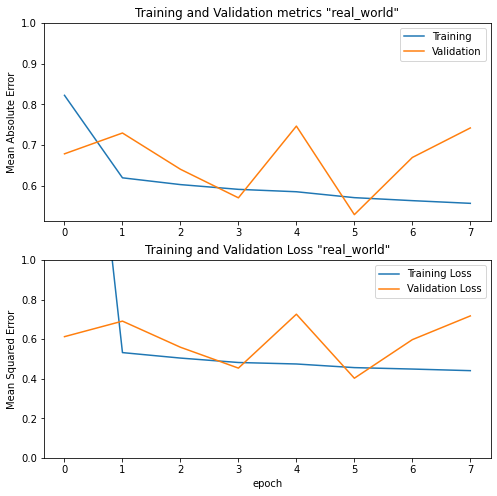

In [117]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training')
plt.plot(val_acc, label='Validation')
plt.legend(loc='upper right')
plt.ylabel('Mean Absolute Error')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation metrics "real_world"')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Mean Squared Error')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss "real_world"')
plt.xlabel('epoch')
plt.show()

In [116]:
# print testing errors on testing data set
print(conv_model.evaluate(conv_window.test, verbose=0))
#conv_model.save('cnn/engineering_models/wind_odor/conv_engineering_{}.h5'.format(CONV_WIDTH), include_optimizer=False)
# prediction
row = np.ones((1, 3, 12))
print(conv_model.predict(np.asarray([row])))

[0.7936808466911316, 0.7699445486068726]


ValueError: in user code:

    File "C:\Users\hp-pc\anaconda3\lib\site-packages\keras\engine\training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\hp-pc\anaconda3\lib\site-packages\keras\engine\training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\hp-pc\anaconda3\lib\site-packages\keras\engine\training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\hp-pc\anaconda3\lib\site-packages\keras\engine\training.py", line 1751, in predict_step
        return self(x, training=False)
    File "C:\Users\hp-pc\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\hp-pc\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_2" is incompatible with the layer: expected shape=(None, 6, 4), found shape=(None, 1, 3, 12)
